# Deep Learning course exam: Visual Grounding

This notebook shows a selected part of the work made for the final exam of the Deep Learning course, attended at the University of Trento in the spring semester of 2023.

The aim of this project is to perform a visual grounding task, starting from a set of images and sentences, implementing the CLIP model. In particular, CLIP should be able to predict which bounding box from a set, present in an image, corresponds to the entity mentioned in the textual description.  

## The data
The dataset RefCOCOg was used, using the split included inside the annotations file.

## The Models
### CLIP
CLIP (Contrastive Language-Image Pre-training) is a multi-modal vision and language model developed by OpenAI.  
It's able to take images and sentences, and encoding them in tensors, which can allow to compute similarities between a text and a picture.
To be able to do so, the model comes pretrained on over 400 million images and captions coming from the whole web.  

The training works by using two encoder functions, Image Encoder and a Text Encoder, that take respectively a batch of images and a batch of descriptions and encode them in two embeddings.  
The model is trained then to maximize the cosine similarity, discerning witch text embedding belongs to a image embedding.   
<td> <img src="https://drive.google.com/uc?export=view&id=1s3uraZwCSwefvZR519J7IUi2rwEMWTQc" alt="Drawing" style="width: 400px;"/> </td>

### YOLO
You only look once (YOLO) is a state-of-the-art, real-time object detection system.   
Its name derives from the fact that, instead of applying the model to an image at multiple locations and scales as the other models, it applies a single neural network to the full image.  
This network divides the image into regions and predicts the bounding boxes and probabilities for each region; they are then weighted by the predicted probabilities.  
The advantage over other methods is that, by looking at the whole image, its predictions are informed of the global context of it. Also using a single network evaluation makes the model 100x times faster than its competitors.  
#### YOLOv8
YOLOv8 is the latest distribution of YOLO and it introduces new features and improvements, boosting performance and flexibility.  
YOLOv8 has a better accuracy than previous YOLO models, other than being faster and less computational burdening.

## The metrics
Through the test, two metrics are computed:
- "YOLO accuracy test" is the average similarity, computed by CLIP, of a sentence to a particular cropped image, defined by YOLO.
- IOU score evaluates the performance of object detection by comparing the ground truth bounding box to the predicted bounding box.

In [1]:
#importing the necessary packages
import random
random.seed(1989)
import torch
from PIL import Image
import json
import numpy as np
import clip
from ultralytics import YOLO
import matplotlib.pyplot as plt
from matplotlib import patches

c:\Users\rober\anaconda3\envs\DeepLearning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#importing CLIP
modelclip, preprocessclip = clip.load("RN50")
modelclip = modelclip.cuda().eval()
device = torch.device("cuda")

In [4]:
#some functions that will be used later

#cleancrops takes the outputs of the yolo model and "tidies up", giving as output a dictionary with number as keys, containing the cropped
#image and the bounding box as a list with the following stucture: [x_corner, y_corner, width, height]
def cleancrops8(crops):
    newcrops = []
    temp = list(crops)
    for c in temp:
        c=c.tolist()
        x_min = c[0]
        y_min = c[1]
        x_max = c[2]
        y_max = c[3]
        bbox = [x_min, y_min, x_max, y_max]
    
        newcrops.append(bbox)

    return newcrops

#cosine similarity computes the similarity between a tensor of an image and a tensor of a text
def cosine_similarity(images_z: torch.Tensor, texts_z: torch.Tensor):
  # normalise the image and the text
  images_z /= images_z.norm(dim=-1, keepdim=True)
  texts_z /= texts_z.norm(dim=-1, keepdim=True)

  # evaluate the cosine similarity between the sets of features
  similarity = (texts_z @ images_z.T)

  return similarity.to(device)

#get an array representing a specific selected area of the image, given the bounding box
def crop_image(image_path, bounding_box):
    # Load the image
    image = Image.open(image_path)
    # Extract the bounding box coordinates
    x_min, y_min, x_max, y_max = bounding_box
    # Crop the image using the bounding box coordinates
    cropped_image = image.crop((x_min, y_min, x_max, y_max))
    # Convert the cropped image to a NumPy array
    cropped_array = np.array(cropped_image)

    return cropped_array

#this function finds the best bounding box for a sentence, between those proposed by yolo
#gives as output the coordinates of the best bounding box and the confidence in assigning it to the sentence
def find_best_yolo_bbox8(sentence, image, net, yolomodel):
    bboxes = yolomodel(image)       #yolo computes the bounding boxes of a given image
    crops = bboxes[0].boxes.data

    goodcrops = cleancrops8(crops)  #fixing them to a usable format

    tok_text = clip.tokenize(sentence).to(device)   #preparing the text

    best_sim = torch.tensor([[0.0]]).to(device)
    best_crop = None

    if len(goodcrops) == 0:
        return [0,0,0,0], 0
    else:
        for crop in goodcrops:
            cropped_image = crop_image(image, crop)                  #clip computes the most similar cropped image 
            img = Image.fromarray(cropped_image)                     #to the given sentence
            img_tens = preprocessclip(img).unsqueeze(0).to(device)

            images_z = net.encode_image(img_tens).float()
            texts_z = net.encode_text(tok_text).float()

            temp_sim = cosine_similarity(images_z, texts_z)
            if temp_sim > best_sim:
                best_sim = temp_sim
                best_crop = crop

    return best_crop, best_sim      #returns the best bounding box and the similarity score


#this function computes the IOU score between two bounding boxes
def get_iou(bb1, bb2):
    #determining the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[0]+bb1[2], bb2[0]+bb2[2])
    y_bottom = min(bb1[1]+bb1[3], bb2[1]+bb2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    #computing the area of both bboxes
    bb1_area = bb1[2] * bb1[3]
    bb2_area = bb2[2] * bb2[3]
    
    #computing iou
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou

# Accuracy tests

In [5]:
#defining the data class for the tests, then calling it with a data loader

class ZeroShotDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, split='test'):
        self.root_dir = root_dir
        self.split = split

        with open(f'{self.root_dir}/annotations/fixedannotations.json') as f:
            data = json.load(f)

        self.annotations = {}

        idx = 0
        for k in data:
            tmp = []
            for v in data[k]:
                if data[k][v]['split'] == self.split:
                    tmp.append(data[k][v])
            if tmp:
                self.annotations[k] = {i: j for i, j in enumerate(tmp)}
                idx += 1
        self.annotations = {idx: {k: self.annotations[k]} for idx, k in enumerate(self.annotations)}

        with open(f'{root_dir}/annotations/instances.json') as f:
            categories = json.load(f)

        self.categories = {}

        for idx, c in enumerate(categories['categories']):
            catid, label = c['id'], c['name']
            self.categories[catid] = label

    def __len__(self):
        return len(self.annotations)
            

    def __getitem__(self, index):
        ret = {}

        temp = self.annotations[index]
        img_name = list(temp.keys())[0]
        img_link = self.root_dir + '/images/'+ img_name

        cap_keys = list(temp[img_name].keys())
        captions = []
        boxes = []

        for item in cap_keys:
            capt = temp[img_name][item]['sentences']
            captions.append(capt[0])                     #as there is multiple captions for one crop, we chose the first one
            boxes.append(temp[img_name][item]['bbox'])
            
        ret["boxes"] = boxes
        ret['captions'] = captions

        return img_link, ret
    
def collate_fn(batch):
    return tuple(zip(*batch))

df_test = ZeroShotDataset(root_dir='insert root directory here', split='test')
test_batch_size = 4   #choose here a batch size for the test
test_loader = torch.utils.data.DataLoader(df_test, test_batch_size, shuffle=False, collate_fn=collate_fn)

Through pre-defined functions we compute the scores mentioned in the introduction. The code below represents the test used throughout this notebook.

In [6]:
def test_yoloclip(net, data_loader, yolomodel):
  samples = 0.0
  cumulative_accuracy = 0.0
  cumulative_iou = 0.0

  #setting the network to evaluation mode
  net.eval()
  #disabling gradient computation for testing
  with torch.no_grad():

    # iterate over the test set
    for batch_num, batch in enumerate(data_loader):
      lungbatch = len(batch)
      for i in range(lungbatch):     #iterate over batch of image links and sentences (stored in a list)
        image_link = batch[0][i]
        sentences = batch[1][i]['captions']
        bboxes = batch[1][i]['boxes']

        if len(sentences) > 0: 
          for i in range(len(sentences)):
            bboxesyolo, similyolo = find_best_yolo_bbox8(sentences[i], image_link, net, yolomodel) #using the function defined before
            iouscore = get_iou(bboxes[i], bboxesyolo) #computing IOU between YOLO bboxes and dataset bboxes

            cumulative_iou += iouscore
            cumulative_accuracy += similyolo
            samples += 1

  return cumulative_accuracy / samples * 100 , cumulative_iou / samples * 100

Now we compute the scores using the original models for CLIP and YOLO (version 8).

In [8]:
yolo_model = YOLO('yolov8n.pt')
test_accuracy, test_iou_score = test_yoloclip(modelclip, test_loader, yolo_model)


image 1/1 C:\Users\rober\Desktop\DL\refcocog\images\COCO_train2014_000000564253.jpg: 320x640 3 persons, 1 surfboard, 54.9ms
Speed: 8.0ms preprocess, 54.9ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\rober\Desktop\DL\refcocog\images\COCO_train2014_000000248835.jpg: 640x480 2 persons, 2 bottles, 14 sandwichs, 2 chairs, 1 dining table, 33.2ms
Speed: 0.0ms preprocess, 33.2ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\rober\Desktop\DL\refcocog\images\COCO_train2014_000000522342.jpg: 480x640 1 motorcycle, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\rober\Desktop\DL\refcocog\images\COCO_train2014_000000522342.jpg: 480x640 1 motorcycle, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\rober\Desktop\DL\refcocog\images\COCO_train2014_000000225213.jpg: 448x640 1 el

In [9]:
print('Yolo test accuracy:', test_accuracy.item())
print('IOU score:', test_iou_score)

Yolo test accuracy: 23.675127029418945
IOU score: 25.23934074647552


The YOLO accuracy is of 23.64%, while the IOU score is of 24.34%. The values are quite low, as the bounding boxes created by YOLO can be quite different from the ones present in the dataset.

# Demo
This demo takes in any picture and a sentence, and proposes a bounding box indicating the region most similar to the sentence.


image 1/1 c:\Users\rober\Desktop\DL\canegatto.jpeg: 448x640 2 dogs, 84.6ms
Speed: 606.0ms preprocess, 84.6ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)


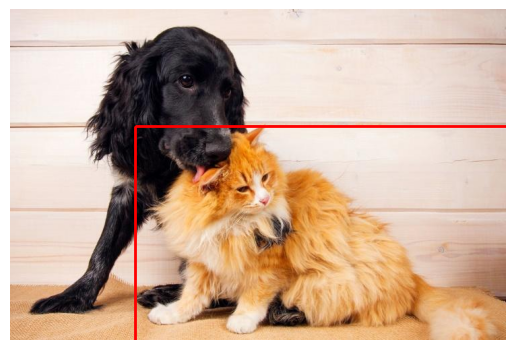

In [14]:
#insert here the image link and the input sentence
image = './canegatto.jpeg'
sentence = 'an orange cat'

coor, _ = find_best_yolo_bbox8(sentence, image, modelclip, yolo_model)

#plotting results
toplot = Image.open(image)
fig, ax = plt.subplots()
# Display the image
plt.imshow(toplot)
ax = plt.gca()
# Create a Rectangle patch
rect = patches.Rectangle((coor[0], coor[1]), coor[2], coor[3], linewidth=2, edgecolor='r', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
ax.set_axis_off()
plt.show()

## Sources
- Open AI - CLIP
- Ultralytics - YOLOv8n
- Slides and notebooks provided during the course